In [ ]:
## Mount on google drive
from google.colab import drive
drive.mount('/content/drive/')
# ## Authenticate to Google Cloud
# from google.colab import auth
# auth.authenticate_user()
## Authenticate to Earth Engine
import ee
ee.Authenticate()
ee.Initialize()


In [ ]:
import os
os.chdir("/content/drive/My Drive/Earth-Engine-with-Deep-Learning")
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from utils import imgShow
import matplotlib.pyplot as plt
import folium  
import time


### Parameters configuration

In [ ]:
## Region for prediction
Area_sz = ee.FeatureCollection('users/xin_luo/shenzhen_shp')
Area_sz_bound = Area_sz.geometry().bounds()
## Data collection
date_year = '2019'
date_start = date_year + '-01-01'  # date of collected data
date_end = date_year + '-12-31'
image = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') # determine satellite image source 
Bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']  # determine the bands to be collected
kernel_buffer = [128, 128]  # left buffer + right buffer = 128, the same to up and down

## Output Google Drive 
# File names of the data colected from Earth Engine.
Image_Folder = 'EE_Image'   # !can't write into the second-level directory
Image_Export_Name = 'Pred-Landsat-8-' + date_year
Image_File_Path = '/content/drive/My Drive/'+Image_Folder+'/'+Image_Export_Name

# Output Cloud Storage bucket.
# Output_Bucket = 'earth-engine-bucket-1'
# Image_File_Path = 'gs://' + Output_Bucket +'/' + Image_Export_Name

In [ ]:
## data source 
image_collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')\
  .filterDate(date_start, date_end)\
  .filterBounds(Area_sz)\
  .filter(ee.Filter.lt('CLOUD_COVER_LAND', 50))

## 1) cloud mask
def cloudMask(image):
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(1<<5).eq(0)
    return image.updateMask(mask)
image_mask = image_collection.map(cloudMask).median()

## 2) fill the null value of the cloud-masked image.
nullMask = image_mask.mask().Not()
img_nullMask = image_collection.map(lambda image_mask: image_mask.updateMask(nullMask)).median()
img_fill = image_mask.unmask(0)\
         .add(img_nullMask.unmask(0))\
         .clip(Area_sz_bound)\
         .divide(10000)\
         .select(Bands)


In [ ]:
# Use folium to visualize the imagery.
mapid = img_fill.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[22.65, 114.17])

folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
map.add_child(folium.LayerControl())
map


In [ ]:
# Specify patch and file dimensions.
image_export_options = {
  'patchDimensions': [256, 256],
  'maxFileSize': 304857600,   # Memory for per TFRecord file
  'kernelSize': kernel_buffer,  ## this parameter is required for the prediction data preparation.
  'compressed': True
}

# Setup the task.
image_task = ee.batch.Export.image.toDrive(
  image=img_fill,
  description = Image_Export_Name,
  fileNamePrefix = Image_Export_Name,
  folder = Image_Folder,
  scale=30,
  fileFormat = 'GeoTIFF',
#   fileFormat='TFRecord',
  region = Area_sz_bound,
#   formatOptions=image_export_options,  # Corresponding to the TFRecord export
)

# Start the task.
image_task.start()
while image_task.active():
  print('Polling for task (id: {}).'.format(image_task.id))
  time.sleep(30)
print('Done with image export.')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


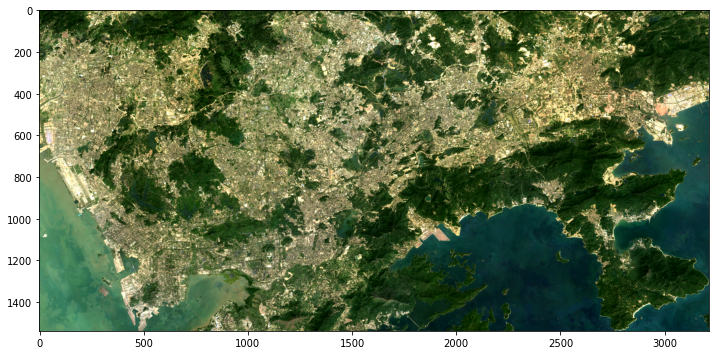

In [ ]:
### visualize the downloaded .tif image
img,im_geotrans,im_proj,im_row,im_col,im_bands = readTiff(Image_File_Path+'.tif')
plt.figure(figsize=(12,6))
imgShow(img,(2,1,0),2)
